In [1]:
#sciezka z danymi
%cd "C:\Users\Dawid\Desktop\kurs\jdszr4-animalsi\wino"

C:\Users\Dawid\Desktop\kurs\jdszr4-animalsi\wino


In [2]:
#glowne biblioteki
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV 
from time import time 
from winsound import Beep
import matplotlib.pyplot as plt
import pickle 

In [103]:
#wlasny modul
from dane.dane_wsadowe_zmiana_klas import *

**1. Prosty model lasow losowych jako benchmark**

a) dane nieprzetworzone 

In [104]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_rf1 = RandomForestClassifier(random_state=6)
model_rf1.fit(X_train_reduced,Y_train_reduced)
pred_rf1 = model_rf1.predict(X_val)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_rf1.score(X_train_reduced, Y_train_reduced),4), "\n",
      "acc val: ", round(model_rf1.score(X_val, Y_val),4))


acc train:  1.0 
 acc val:  0.9375


In [105]:
#ocena jakosci modelu nr 1
rf1_cnf_matrix = confusion_matrix(Y_val, pred_rf1)
rf1_cnf_raport = classification_report(Y_val, pred_rf1)
print(rf1_cnf_raport)
print(rf1_cnf_matrix)

              precision    recall  f1-score   support

           1       0.94      0.99      0.96       111
           2       0.91      0.59      0.71        17

    accuracy                           0.94       128
   macro avg       0.92      0.79      0.84       128
weighted avg       0.94      0.94      0.93       128

[[110   1]
 [  7  10]]


Ocena pierwszego modelu, model jak mozna bylo się spodziewać dobrze przewiduje klase najbardziej liczna, ale slaba trafia w klasę 2.

b) dane przeskalowane

In [101]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_rf2 = RandomForestClassifier(random_state=6)
model_rf2.fit(X_train_reduced_scaled,Y_train_reduced)
pred_rf2 = model_rf2.predict(X_val_scaled)

In [58]:
#ocena jakosci modelu nr 2
rf2_cnf_matrix = confusion_matrix(Y_val, pred_rf2)
rf2_cnf_raport = classification_report(Y_val, pred_rf2)
print(rf2_cnf_raport)
print(rf2_cnf_matrix)

              precision    recall  f1-score   support

           1       0.94      0.99      0.96       111
           2       0.91      0.59      0.71        17

    accuracy                           0.94       128
   macro avg       0.92      0.79      0.84       128
weighted avg       0.94      0.94      0.93       128

[[110   1]
 [  7  10]]


Przy przeskalowanych danych wyniki nie zmieniły się.

c) dane PCA

In [29]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_rf3 = RandomForestClassifier(random_state=6)
model_rf3.fit(X_train_reduced_scaled_PCA,Y_train_reduced)
pred_rf3 = model_rf3.predict(X_val_scaled_PCA)

In [28]:
#ocena jakosci modelu nr 3
rf3_cnf_matrix = confusion_matrix(Y_val, pred_rf3)
rf3_cnf_raport = classification_report(Y_val, pred_rf3)
print(rf3_cnf_raport)
print(rf3_cnf_matrix)

              precision    recall  f1-score   support

           1       0.94      0.99      0.96       111
           2       0.91      0.59      0.71        17

    accuracy                           0.94       128
   macro avg       0.92      0.79      0.84       128
weighted avg       0.94      0.94      0.93       128

[[110   1]
 [  7  10]]


Przy PCA wyniki nie poprawiły się.

**2. Znajdzmy najlepsze parametry dla tego modelu**

In [82]:
#zacznijmy od małego zestawu, by dostrzec czy jest w ogóle jakas poprawa
params_rf1 = {"max_depth"        :[10,12,14,16,None],
              "n_estimators"     :list(range(20,101,20)),
              "min_samples_leaf" :list(range(1, 5, 1)),
              "max_features"     :[4,8,None]
}

In [83]:
r=  0   # policzymy ile jest mozliwych kombinacji parametrow
for j in params_rf1.values():
    s=len(j)
    r += s
r

17

- wykorzystajmy model oparty na nieprzetworzonych danych

In [84]:
#zdefiniujmy obiekt sprawdzajacy nasze parametry
skf= StratifiedKFold(n_splits=5, shuffle = True)
grid_search1 =  GridSearchCV(RandomForestClassifier(random_state=6),param_grid = params_rf1,cv =skf,verbose = 1,n_jobs = 2,scoring = make_scorer(f1_score, average = "macro")).fit(X_train_all,Y_train_all)
Beep(400,1000)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done 258 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 858 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 1308 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  6.3min finished


In [85]:
# sprawdzmy nasz najlepszy zestaw parametrow
print(grid_search1.best_params_)

model_rf4 = grid_search1.best_estimator_
model_rf4.fit(X_train_all,Y_train_all)

pred_rf4 = model_rf4.predict(X_test)

{'max_depth': 12, 'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 100}


In [86]:
#ocena jakosci modelu z wybranymi najlepszymi parametrami
rf4_cnf_matrix = confusion_matrix(Y_test, pred_rf4)
rf4_cnf_raport = classification_report(Y_test, pred_rf4)
print(rf4_cnf_raport)
print(rf4_cnf_matrix)

              precision    recall  f1-score   support

           1       0.94      0.94      0.94       280
           2       0.58      0.55      0.56        40

    accuracy                           0.89       320
   macro avg       0.76      0.75      0.75       320
weighted avg       0.89      0.89      0.89       320

[[264  16]
 [ 18  22]]


Widzimy calkiem dobry wynik F1 score dla klasy 2. spróbujmy jeszcze przepracować niezbalansowanie klas.


**3. Popracujmy nad niezbalansowaniem klas**

In [87]:
# dobierzmy jeszcze do naszego najlepszego modelu najbardziej optymalny zestaw wag
weights = np.linspace(0.05,0.95,30)
params_weight1 = {"class_weight": [{1:x, 2: 1-x} for x in weights]}

In [88]:
#zdefiniujmy obiekt sprawdzajacy nasze losowane wagi na ostatnim wyliczonym modelu
grid_search2 =  GridSearchCV(grid_search1.best_estimator_,param_grid = params_weight1,cv =skf,verbose = 1,n_jobs = 3,scoring = make_scorer(f1_score, average = "macro")).fit(X_train_all,Y_train_all)
Beep(400,1000)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:  1.0min finished


In [89]:
# sprawdzmy jaki jest nasz najlepszy zestaw wag
print(grid_search2.best_params_)

model_rf5 = grid_search2.best_estimator_
model_rf5.fit(X_train_all,Y_train_all)

pred_rf5 = model_rf5.predict(X_test)

{'class_weight': {1: 0.2982758620689655, 2: 0.7017241379310345}}


In [92]:
#nasz dotychczasowy najlepszy model
grid_search2.best_estimator_

RandomForestClassifier(class_weight={1: 0.2982758620689655,
                                     2: 0.7017241379310345},
                       max_depth=12, max_features=8, random_state=6)

In [93]:
#ocena jakosci modelu z wybranymi najlepszymi wagami i parametrami
rf5_cnf_matrix = confusion_matrix(Y_test, pred_rf5)
rf5_cnf_raport = classification_report(Y_test, pred_rf5)
print(rf5_cnf_raport)
print(rf5_cnf_matrix)

              precision    recall  f1-score   support

           1       0.94      0.94      0.94       280
           2       0.60      0.60      0.60        40

    accuracy                           0.90       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.90      0.90      0.90       320

[[264  16]
 [ 16  24]]


Nasz model z wyważonymi wagami klas osiągnał już całkiem dobrą dokładność dla klasy 2, ale może uda się jeszcze go poprawić.

**4. Pole pod krzywą ROC**   
- próba znalezienia wydajniejszej klasyfikacji przy zmianie progu klasyfikacji

In [94]:
#wyciagnijmy nie klasyfikacje a prawdopodobienstwa
Y_pred_rf5_proba = model_rf5.predict_proba(X_test)[::,1]

#wykreslenie krzywej ROC
FPR, TPR, tresholds = roc_curve(Y_test, Y_pred_rf5_proba,pos_label=2)

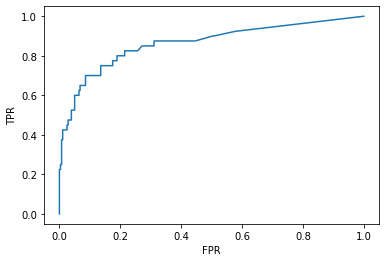

In [95]:
#poniżej mozemy zobaczyć jak prezentuje się nasz TPR vs FPR
plt.plot(FPR, TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Zastosujmy inne przypisanie  progow i sprawdzmy nasz wynik

In [96]:
lista = []
zbior_i = []
zbior_f1 = []
for i in np.linspace(0.1,0.9,30):
    lista = [2 if Y_pred_rf5_proba[x] >= i else 1 for x in range(Y_pred_rf5_proba.size)]
    print("trashold ="+ str(round(i,2)) + ", F1 score= " + str(round(f1_score(Y_test, lista,average = 'macro'),2)))
    zbior_i.append(i)
    zbior_f1.append(round(f1_score(Y_test, lista,average = 'macro'),2))

trashold =0.1, F1 score= 0.63
trashold =0.13, F1 score= 0.66
trashold =0.16, F1 score= 0.68
trashold =0.18, F1 score= 0.7
trashold =0.21, F1 score= 0.71
trashold =0.24, F1 score= 0.73
trashold =0.27, F1 score= 0.73
trashold =0.29, F1 score= 0.74
trashold =0.32, F1 score= 0.75
trashold =0.35, F1 score= 0.76
trashold =0.38, F1 score= 0.75
trashold =0.4, F1 score= 0.76
trashold =0.43, F1 score= 0.77
trashold =0.46, F1 score= 0.77
trashold =0.49, F1 score= 0.76
trashold =0.51, F1 score= 0.77
trashold =0.54, F1 score= 0.75
trashold =0.57, F1 score= 0.74
trashold =0.6, F1 score= 0.76
trashold =0.62, F1 score= 0.74
trashold =0.65, F1 score= 0.76
trashold =0.68, F1 score= 0.73
trashold =0.71, F1 score= 0.68
trashold =0.73, F1 score= 0.65
trashold =0.76, F1 score= 0.66
trashold =0.79, F1 score= 0.64
trashold =0.82, F1 score= 0.62
trashold =0.84, F1 score= 0.54
trashold =0.87, F1 score= 0.52
trashold =0.9, F1 score= 0.52


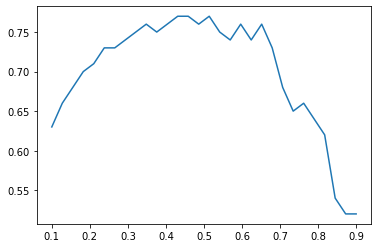

In [97]:
plt.plot(zbior_i,zbior_f1)
pass

In [98]:
#pozycja najlepszego wyniku
pozycja = np.min(np.where(zbior_f1 == np.max(zbior_f1)))
#najlepszy wynik wypada przy progu
prog = zbior_i[pozycja]
prog 

0.4310344827586208

In [99]:
# Sprawdzmy dokladnosc modelu przy tym progu
Y_pred_rf5_prog = [2 if Y_pred_rf5_proba[x] >= prog else 1 for x in range(Y_pred_rf5_proba.size)]

In [100]:
#ocena jakosci modelu na nowym progu
rf5_prog_cnf_matrix = confusion_matrix(Y_test, Y_pred_rf5_prog)
rf5_prog_cnf_raport = classification_report(Y_test, Y_pred_rf5_prog)
print(rf5_prog_cnf_raport)
print(rf5_prog_cnf_matrix)

              precision    recall  f1-score   support

           1       0.95      0.93      0.94       280
           2       0.57      0.65      0.60        40

    accuracy                           0.89       320
   macro avg       0.76      0.79      0.77       320
weighted avg       0.90      0.89      0.90       320

[[260  20]
 [ 14  26]]


Nasz ostateczny model uzyskał dokładność 91%, z 94% precyzja wskazuje dobrze klase 1 a z 69% klasę 2. 

**5. Nasz najlepszy model**

In [28]:
model_rf5_final = grid_search2.best_estimator_
model_rf5_final.fit(X_train_all,Y_train_all)

pred_rf5_final = model_rf5.predict_proba(X_test)[:,1] >= prog
#y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)

In [29]:
#ocena jakosci modelu z wybranymi najlepszymi wagami i parametrami
rf5_final_cnf_matrix = confusion_matrix(Y_test, pred_rf5_final)
rf5_final_cnf_raport = classification_report(Y_test, pred_rf5_final)
print(rf5_final_cnf_raport)
print(rf5_final_cnf_matrix)

              precision    recall  f1-score   support

           1       0.93      0.97      0.95       274
           2       0.74      0.54      0.62        46

    accuracy                           0.91       320
   macro avg       0.83      0.76      0.79       320
weighted avg       0.90      0.91      0.90       320

[[265   9]
 [ 21  25]]


In [25]:
import pickle

In [ ]:
#pakuje model do zmiennej pickle
# ?? pytanie jak potem z klasyfikacja wobec progu??
with open ("model_rf_final", "wb") as file:
    pickle.dump(model_rf5_final, file)